In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#CSV file already cleaned. No Nans or missing values. this was done wth ffill and bffill.<-- maybe imputing would be better?
df = pd.read_csv('vehicles_cleaned.csv',index_col= 0)


In [3]:
display(df.head())

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type
0,6450,2006.0,acura,200,excellent,6 cylinders,gas,122000.0,automatic,fwd,full-size,sedan
1,5270,2006.0,acura,200,excellent,6 cylinders,gas,103000.0,automatic,fwd,mid-size,sedan
2,3500,1991.0,audi,200,good,5 cylinders,gas,120000.0,automatic,4wd,mid-size,sedan
3,8000,2010.0,chevrolet,200,good,6 cylinders,gas,100000.0,automatic,fwd,full-size,sedan
4,8000,2016.0,chevrolet,200,good,6 cylinders,gas,70000.0,automatic,fwd,full-size,sedan


In [4]:
# 12 features, 304051 cars sold!
df.shape

(304051, 12)

In [5]:
# Price is the Target Variable.
#Year and Odometer (mileage) are NUMERICAL FEATURES,
#Cylinders should be changed to Numerical
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304051 entries, 0 to 312725
Data columns (total 12 columns):
price           304051 non-null int64
year            304051 non-null float64
manufacturer    304051 non-null object
model           304051 non-null object
condition       304051 non-null object
cylinders       304051 non-null object
fuel            304051 non-null object
odometer        304051 non-null float64
transmission    304051 non-null object
drive           304051 non-null object
size            304051 non-null object
type            304051 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 30.2+ MB


None

In [6]:
#'Cylinders' Column = Numerical
cleanup_nums = {"12 cylinders" : 12, "10 cylinders": 10,"8 cylinders": 8,"6 cylinders": 6,'5 cylinders':5,"4 cylinders":4,"3 cylinders": 3 }
df.cylinders.replace(cleanup_nums, inplace=True, regex=True)

df.cylinders.value_counts()

6     105339
4     103661
8      91412
5       1802
10      1574
3        249
12        14
Name: cylinders, dtype: int64

In [7]:
#Dropping 'cylinders' <3 & <12 
df = df[df['cylinders'] > 3]
df = df[df['cylinders'] < 10]

In [8]:
#Cylinders Numeric <-- good for ML models
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302214 entries, 0 to 312725
Data columns (total 12 columns):
price           302214 non-null int64
year            302214 non-null float64
manufacturer    302214 non-null object
model           302214 non-null object
condition       302214 non-null object
cylinders       302214 non-null int64
fuel            302214 non-null object
odometer        302214 non-null float64
transmission    302214 non-null object
drive           302214 non-null object
size            302214 non-null object
type            302214 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 30.0+ MB


None

In [9]:
#Model, Manufacturer, Condition, Transmission, Drive, Size, Type are CATEGORICAL FEATURES 

In [10]:
#the Categorical columns and the count values
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    print(df[col].value_counts())

ford             58784
chevrolet        45759
toyota           25992
nissan           17943
honda            17272
ram              17161
jeep             16578
gmc              15281
dodge            10198
hyundai           8460
subaru            8136
bmw               6378
kia               6124
volkswagen        5539
chrysler          5420
volvo             4817
cadillac          4320
mercedes-benz     4153
buick             3981
mazda             2841
audi              2695
lexus             2683
infiniti          2320
acura             2220
lincoln           1735
mini              1472
pontiac           1109
mitsubishi         981
saturn             620
fiat               515
rover              373
mercury            331
jaguar              23
Name: manufacturer, dtype: int64
silverado    17154
500          15609
f-150         9867
sierra        7319
wrangler      6957
             ...  
xc90           313
gx             307
gl-class       305
es 350         304
535i           302

In [11]:
# --Trucks and pickup truck dominate the market , Followed By SUVS, sedans

In [12]:
#The Plan:
# Manufacturer,Mpdel,Drive,Transmission, are good.
# Condition: = drop salvage. 
# Fuel: assuming electric ~ =  hybrid
# Size: drop bus, assuming pickup ~ truck, 
# price = min 1600$ for vehicle

In [13]:
# Dropping cars that are non-functional
df = df[~(df['condition'] == 'salvage')]


In [14]:
# Electric ~= Hybrid
df['fuel'] = df['fuel'].apply(lambda x: 'hybrid' if 'electric' in x else x)
# setting sub-compact = compact
df['size'] = df['size'].apply(lambda x: 'compact' if 'sub-compact' in x else x)
#pickup = truck
df['type'] = df['type'].apply(lambda x: 'truck' if 'pickup' in x else x)
# Dropping Bus
df = df[~(df['type'] == 'bus')]
df = df[~(df['type'] == 'offroad')]
df = df[~(df['type'] == 'other')]
#Min Car price = 1600$
df = df[df['price'] > 3000]
df = df[df['price'] < 60000]
#min year > 1990
df = df[df['year'] > 1995]

In [15]:
# Key takeaways from the table:
#  Mean car price ~ 15,000 , Mean year = 2011, mean odometer ~ 100,000                                
df.describe()

,price,year,cylinders,odometer
count,272249.000000,272249.000000,272249.000000,272249.000000
mean,14922.469082,2011.643991,5.937587,101518.152350
std,9960.881264,4.752856,1.611992,55859.518545
min,3035.000000,1996.000000,4.000000,1001.000000
25%,6999.000000,2008.000000,4.000000,56503.000000
50%,12495.000000,2012.000000,6.000000,99000.000000
75%,19950.000000,2015.000000,8.000000,139032.000000
max,59999.000000,2021.000000,8.000000,299999.000000


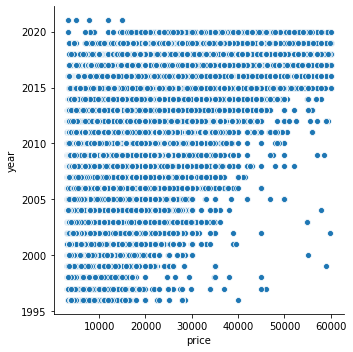

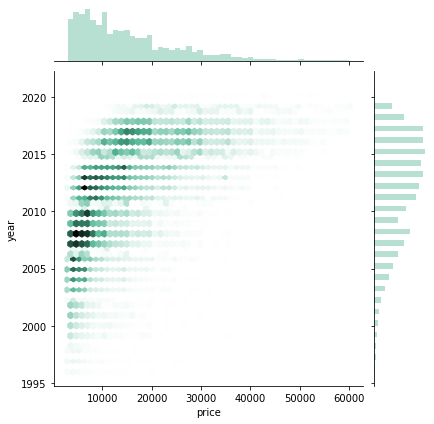

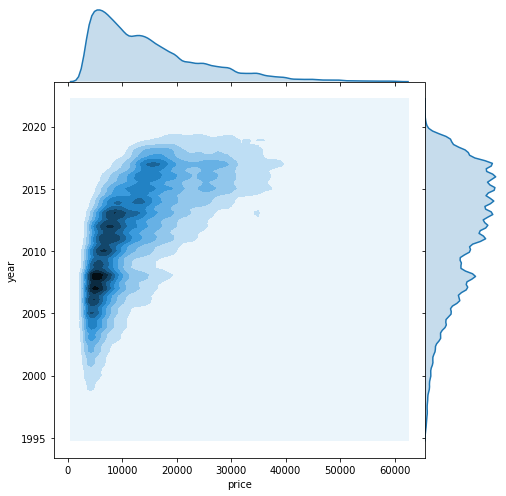

In [16]:
#lets Look at prices relation with numerical columns:
#Price and year:
#insights:
ax = sns.relplot(x="price", y="year", data=df)
ax = sns.jointplot(x = df['price'], y= df['year'], kind='hex', color="#4CB391")
ax = sns.jointplot(df['price'], df['year'], kind="kde", height=7, space=0)

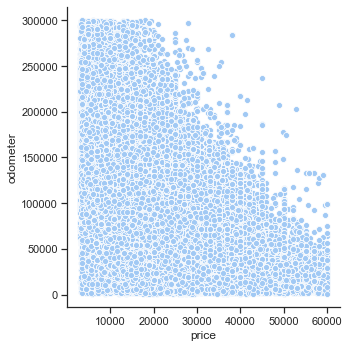

In [17]:
#Price and Odometer:
#Insights = most cars are between 100,000 an less 10,000

sns.set(style="ticks", palette="pastel")
ax = sns.relplot(x="price", y="odometer", data=df)

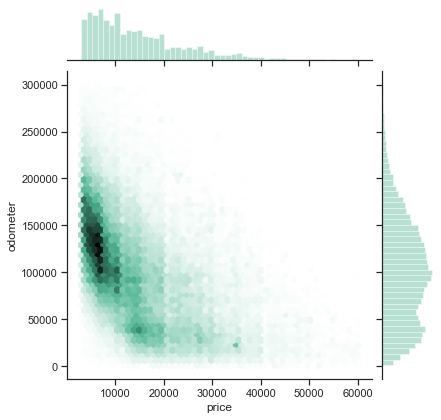

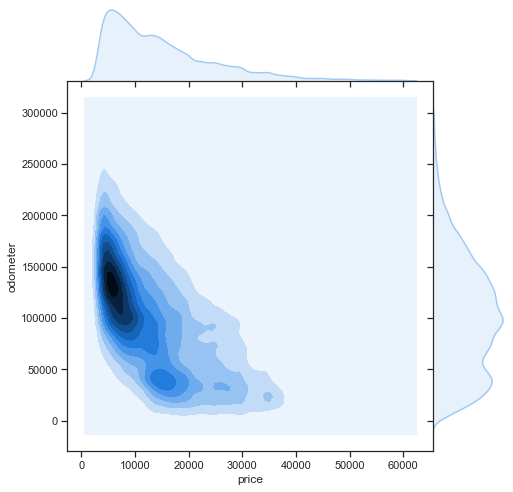

In [18]:
#kernal Density PLots 
ax = sns.jointplot(x = df['price'], y= df['odometer'], kind='hex', color="#4CB391")
ax = sns.jointplot(df['price'], df['odometer'], kind="kde", height=7, space=0)

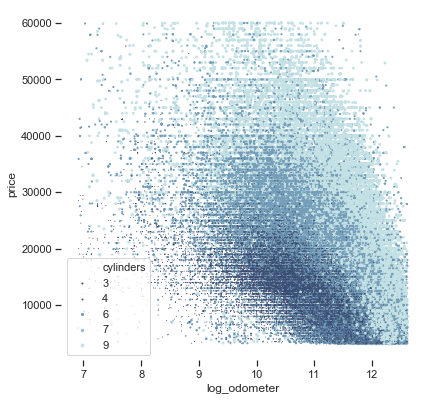

In [19]:
# log Odometer on price
df['log_odometer']  = np.log(df['odometer'])
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="log_odometer", y="price",
                hue="cylinders", size="cylinders",
                palette="ch:r=-.2,d=.3_r",
                
                sizes=(1, 8), linewidth=0,
                data=df, ax=ax)

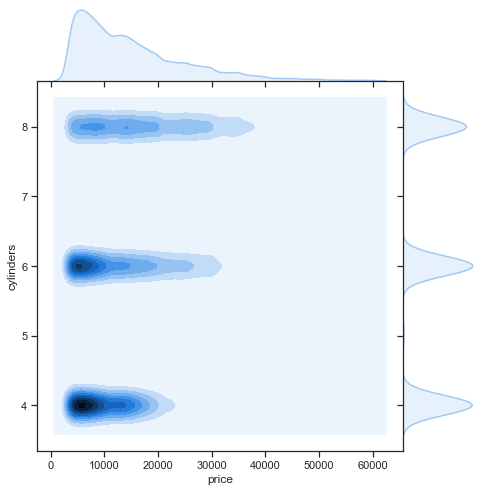

In [20]:
# Price and cylinders  
ax = sns.jointplot(df['price'], df['cylinders'], kind="kde", height=7, space=0)

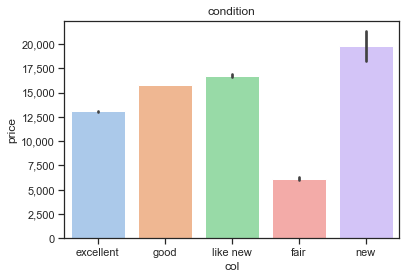

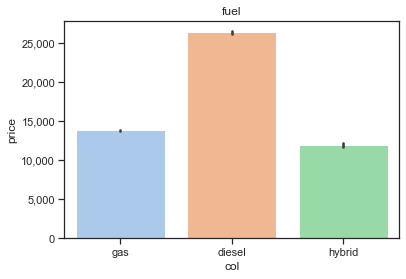

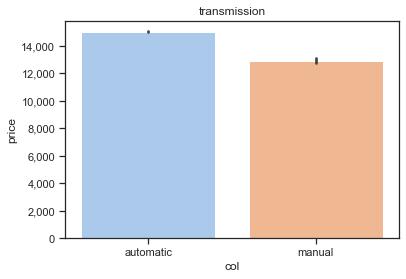

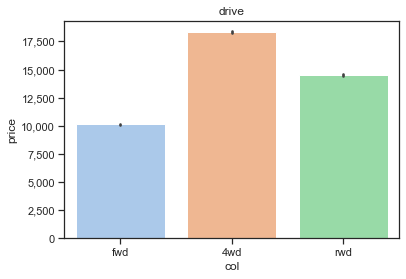

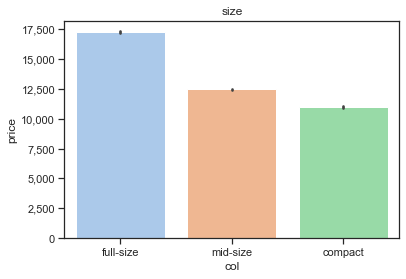

In [21]:
# Visualizing Categorical Data 
#insights 

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cofit = [c for c in cat_cols if c not in ['model','manufacturer','type']] 



for col in cat_cofit :
               
        plt.figure(figsize=(6,4))
        ax = sns.barplot(data=df, x= col, y = 'price')
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.set(xlabel="col", ylabel='price')
        ax.set(ylabel = 'price')
        plt.title(col)
        plt.show()


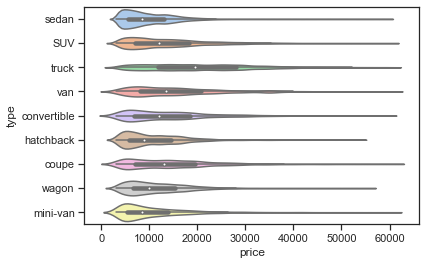

In [22]:
#Price by type 
sns.violinplot(data=df, y='type', x='price')


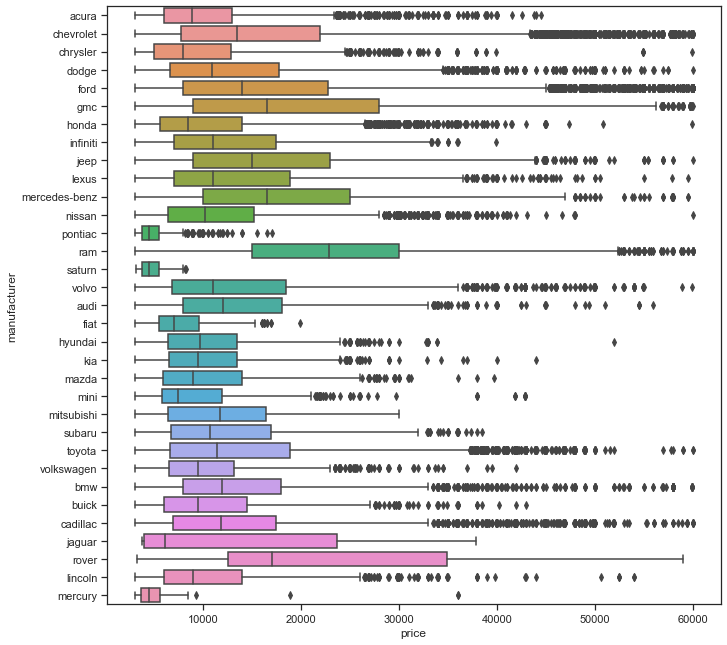

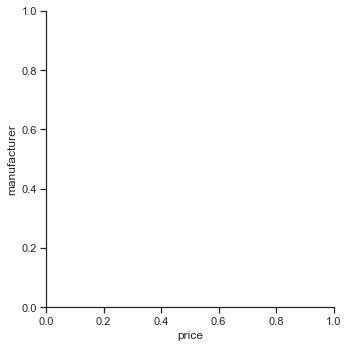

In [28]:
#Box Plot of car prices by cylinders for each manufacturer  
#Key Insights from Boxplot:
#Many Many OUTLIERS!!
#8cylinder manufacturers: Chevrolet,Ford, GMC,Nissan,Ram,Toyota
#6 clinders
dim = (11, 11)
fig, ax = plt.subplots(figsize=dim)
sns.catplot(ax=ax, data=df, x ='price',y='manufacturer',kind='box' )


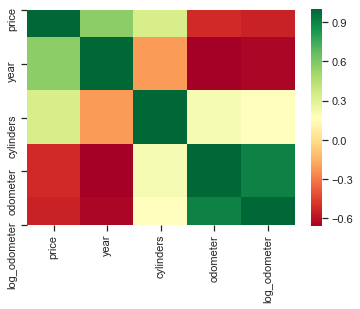

In [30]:
#Correlation map Insights:
#insights: newer cars have fewer cylinders?
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [31]:
#convert categorical data into numerical 
from sklearn import preprocessing 
import pandas as pd


df= pd.get_dummies(df, prefix=['manufacturer','model','condition','fuel','drive','transmission','size','type'], columns=['manufacturer','model','condition','fuel','drive','transmission','size','type'])
print(df.shape)
df.head()


(272249, 250)


,price,year,cylinders,odometer,log_odometer,manufacturer_acura,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,size_mid-size,type_SUV,type_convertible,type_coupe,type_hatchback,type_mini-van,type_sedan,type_truck,type_van,type_wagon
0,6450,2006.0,6,122000.0,11.711776,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5270,2006.0,6,103000.0,11.542484,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,8000,2010.0,6,100000.0,11.512925,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,8000,2016.0,6,70000.0,11.156251,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,3800,2011.0,4,127800.0,11.758222,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [36]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler

y = df.price.values
X = df.drop('price', axis= 1)

features = list(X.columns)
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 40)

sc = MinMaxScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.fit_transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(204186, 249)
(204186,)
(68063, 249)
(68063,)


In [38]:
#scale with minmaxscaler

from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


rmse_test=[]
rmse_train=[]
best_iters=[]
   
#
params = {
    'objective':'reg:linear',
    'colsample_bytree': 0.7,
    'n_estimators': 180,
    'max_depth': 8,
    'eta' :0.05,
    'subsample':1,
    'seed':4
    }
num_round= 300
progress={}

D_train = xgb.DMatrix(data=X_train, label=y_train)
D_test =  xgb.DMatrix(data=X_test, label=y_test)

watchlist=[(D_train,'train'),(D_test,'test')]
bst = xgb.train(params ,D_train, num_round, evals=watchlist,early_stopping_rounds=5,evals_result=progress)

#Cross Validation nfolds=4
cv_results = xgb.cv(dtrain=D_train, params=params, nfold=4, num_boost_round=num_round, metrics="rmse", as_pandas=True, seed=123)

pred_test = bst.predict(D_test)
pred_train = bst.predict(D_train)

train_rmse = MSE(y_train, pred_train)**(1/2)
test_rmse = MSE(y_test, pred_test)**(1/2)

rmse_test.append(test_rmse)
rmse_train.append(train_rmse)
best_iters.append(bst.best_iteration)

print((cv_results["test-rmse-mean"]).tail(1))



[20:29:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:17112.8	test-rmse:17092.1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 5 rounds.
[1]	train-rmse:16314.1	test-rmse:16296.5
[2]	train-rmse:15565.5	test-rmse:15550.9
[3]	train-rmse:14866.5	test-rmse:14854.9
[4]	train-rmse:14215.3	test-rmse:14206.1
[5]	train-rmse:13589.5	test-rmse:13583.2
[6]	train-rmse:12974.4	test-rmse:12971.4
[7]	train-rmse:12391.6	test-rmse:12391.1
[8]	train-rmse:11860.4	test-rmse:11863
[9]	train-rmse:11338.1	test-rmse:11343.6
[10]	train-rmse:10863.4	test-rmse:10872.1
[11]	train-rmse:10417.5	test-rmse:10429.1
[12]	train-rmse:9974.92	test-rmse:9989.54
[13]	train-rmse:9579.1	test-rmse:9596.59
[14]	train-rmse:9186.42	test-rmse:9206.23
[15]	train-rmse:8809.56	test-rmse:8832.74
[16]	train-rmse:8455.63	test-rmse:8481
[17]	train-rmse:8121.3	test-rmse:8149.95
[18

[189]	train-rmse:3152.82	test-rmse:3296.74
[190]	train-rmse:3151.86	test-rmse:3296.1
[191]	train-rmse:3151.3	test-rmse:3295.69
[192]	train-rmse:3150.8	test-rmse:3295.21
[193]	train-rmse:3149.88	test-rmse:3294.57
[194]	train-rmse:3148.86	test-rmse:3293.81
[195]	train-rmse:3148.41	test-rmse:3293.37
[196]	train-rmse:3147.72	test-rmse:3292.85
[197]	train-rmse:3146.88	test-rmse:3292.18
[198]	train-rmse:3146.36	test-rmse:3291.86
[199]	train-rmse:3145.73	test-rmse:3291.35
[200]	train-rmse:3144.9	test-rmse:3290.82
[201]	train-rmse:3144.42	test-rmse:3290.38
[202]	train-rmse:3143.14	test-rmse:3289.28
[203]	train-rmse:3142.17	test-rmse:3288.56
[204]	train-rmse:3140.9	test-rmse:3287.57
[205]	train-rmse:3140.37	test-rmse:3287.18
[206]	train-rmse:3139.8	test-rmse:3286.71
[207]	train-rmse:3139.07	test-rmse:3286.27
[208]	train-rmse:3138.39	test-rmse:3285.71
[209]	train-rmse:3137.83	test-rmse:3285.28
[210]	train-rmse:3136.79	test-rmse:3284.3
[211]	train-rmse:3135.52	test-rmse:3283.33
[212]	train-rmse:3

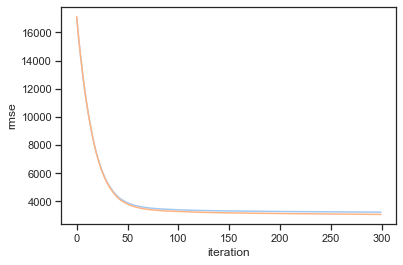

In [40]:
plt.plot([i for i in range(num_round)],progress['test']['rmse'],label='train')
plt.plot([i for i in range(num_round)],progress['train']['rmse'],label='train')
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.show()


linear Regression : 4343.460
lasso Regression : 4632.194
randomforest : 4913.049
decisionTree : 5009.265
Root Mean Squared Error: 4338.6776748591865


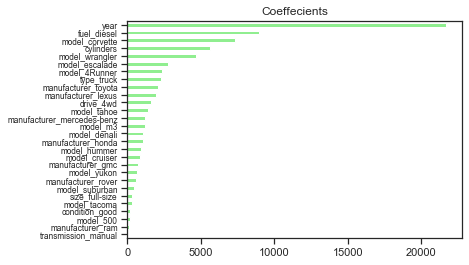

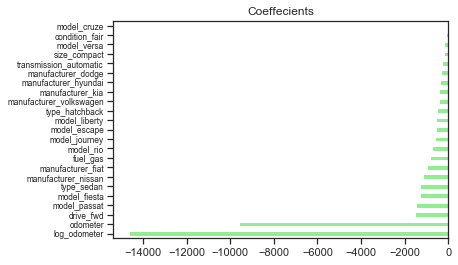

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE



#Intialize weak learner into ensemble with voting regressor
lr = LinearRegression()
lasso = Lasso(alpha= 0.4, normalize=True)
dt = DecisionTreeRegressor(max_depth=6,min_samples_leaf=0.01,random_state=10)
rf = RandomForestRegressor(n_estimators=200,min_samples_leaf=0.01,random_state=2)
#list of tuples, weak learners
regressors = [('linear Regression', lr), ('lasso Regression', lasso), ('randomforest', rf),('decisionTree', dt)]
# Iterate over each weak learner 
for clf_name, clf in regressors:
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    rmse = np.sqrt(MSE(y_test, y_pred))
    print('{:s} : {:.3f}'.format(clf_name, rmse))
    
#Fit and predict with voting regresor
vc = VotingRegressor(estimators=regressors)     
vc.fit(X_train,y_train)   
y_pred = vc.predict(X_test)

rmse = np.sqrt(MSE(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

#Lasso coefficents
importances = pd.Series(data=lasso.fit(X_train, y_train).coef_, index= features)

importances_sorted = importances.sort_values()
positive_importance = importances_sorted[importances_sorted > 0]
negative_importance = importances_sorted[importances_sorted < 0]

#positive & negative Lasso plots
positive_importance.plot(kind='barh', color='lightgreen')
plt.title('Coeffecients')
plt.yticks(horizontalalignment='right',fontweight='light',fontsize='x-small' )
plt.show()

negative_importance.plot(kind='barh', color='lightgreen')
plt.title('Coeffecients')
plt.yticks(horizontalalignment='right',fontweight='light',fontsize='x-small' )
plt.show()



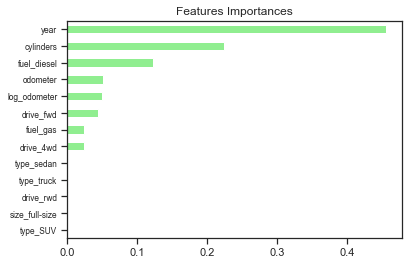

In [42]:
importances = pd.Series(data=rf.feature_importances_,
                        index= features)

# Sort importances
importances_sorted = importances.sort_values()
top_importance = importances_sorted[importances_sorted > 0]

# barplot of importances
top_importance.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.yticks(horizontalalignment='right',
    fontweight='light',
    fontsize='x-small' )


plt.show()